Number of stars used: 8
Radius at 50% EE: 0.5


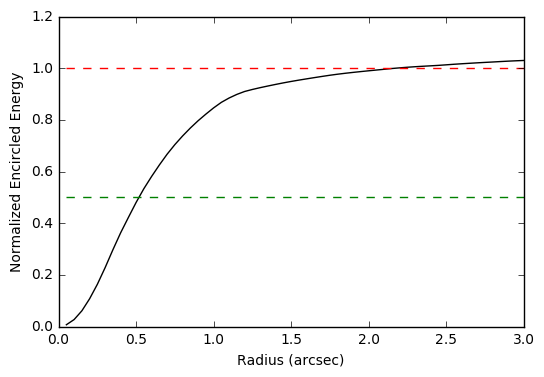

In [104]:
from astropy.stats import sigma_clipped_stats
from photutils import datasets
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
import numpy as np
from photutils import DAOStarFinder
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.io import fits
import reduce_20161118 as red 
%matplotlib inline

image = fits.getdata("../../../20170111/Pleiades/closed_red/obj_c007_bin_nobkg.fits")
binfac = 10    #bin images
max_rad = 3    #maximum radius to measure encircled energies in (arcseconds)
max_flux = 1.0 #flux cutoff for sources to be uced in EE calculation

data = red.rebin(image, binfac)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5)    

daofind = DAOStarFinder(fwhm=1.0, threshold=5.*std)    
sources = daofind(data - median)  
data_array = np.array(sources) #remove edge sources, within 5 pixels
removes = []
for i in range(len(data_array)):
    if 268 > data_array[i][1] > 5 and 200 > data_array[i][2] > 5 \
    and data_array[i][-2] > max_flux:
        pass
    else:
        removes.append(i)
removes = list(removes)
sources.remove_rows(removes)

#for showing image with usable sources marked:

#positions = (sources['xcentroid'], sources['ycentroid'])
#apertures = CircularAperture(positions, r=4.)
#norm = ImageNormalize(stretch=SqrtStretch())
#plt.imshow(data, cmap='Greys', origin='lower', norm=norm)
#apertures.plot(color='blue', lw=1.5, alpha=0.5)
#annulus.plot(color='red', lw=1.5, alpha=0.5)


#Calculate encircled energies

original_plate_scale = 23.0 #mas/pixel
plate_scale_arcsec = original_plate_scale * 3 * binfac * 1e-3 #as/pix, (binned twice)
radii = np.linspace(0.05, max_rad, max_rad*20)

energy_array = []
for i in range(len(sources)): 

    positions = [sources[i][1], sources[i][2]] 

    annulus = CircularAnnulus(positions, max_rad/plate_scale_arcsec, (max_rad+1)/plate_scale_arcsec)
    bkg = aperture_photometry(data, annulus)
    bkg_mean = bkg['aperture_sum'][0]/annulus.area()

    energies = []

    for radius in radii:

        radius_pixel = radius / plate_scale_arcsec
        apertures = CircularAperture(positions, r=radius_pixel)
        phot_table = aperture_photometry(data, apertures)

        energy = phot_table[0][3]

        bkg_sum = apertures.area() * bkg_mean
        final_energy = energy - bkg_sum  

        energies.append(final_energy)

    fit_line = np.polyfit(radii[30:], energies[30:], deg=0)[0]

    norm_energies = energies / fit_line

    energy_array.append(norm_energies)

ave_energies = np.mean(energy_array, axis=0)
rad_at_pt5 = radii[(np.abs(ave_energies-0.5)).argmin()]
    
print("Number of stars used:", len(sources))
print("Radius at 50% EE:", rad_at_pt5)
    
plt.plot(radii, ave_energies, 'k-')
plt.plot(radii, np.ones(len(radii)), 'r--')
plt.plot(radii, np.ones(len(radii))*0.5, 'g--')
plt.xlabel("Radius (arcsec)")
plt.ylabel("Normalized Encircled Energy")

In [111]:
import pylab as plt
from PIL import Image
import numpy as np
from astropy.io import fits
from astropy import table
from astropy import units
import glob
import photutils
from photutils import psf
from photutils import morphology as morph
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
import poppy
import pdb
#from astroscrappy import detect_cosmics
import pylab as plt
from PIL import Image
import numpy as np
from astropy.io import fits
from astropy import table
from astropy import units
import glob
import photutils
from photutils import psf
from photutils import morphology as morph
from photutils import DAOStarFinder
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting
import poppy
import pdb

def find_stars_bin(img_files, fwhm=5, threshold=4, N_passes=2):
    for ii in range(len(img_files)):
        print("Working on image: ", img_files[ii])
        img = red.rebin(fits.getdata(img_files[ii]), 10)

        # Calculate the bacgkround and noise (iteratively)
        print("      Calculating background")
        bkg_threshold = 3
        for nn in range(5):
            if nn == 0:
                bkg_mean = img.mean()
                bkg_std = img.std()
            else:
                bkg_mean = img[good_pix].mean()
                bkg_std = img[good_pix].std()

            bad_hi = bkg_mean + (bkg_threshold * bkg_std)
            bad_lo = bkg_mean - (bkg_threshold * bkg_std)

            good_pix = np.where((img < bad_hi) & (img > bad_lo))
        
        bkg_mean = img[good_pix].mean()
        bkg_std = img[good_pix].std()
        img_threshold = threshold * bkg_std
        print('     Bkg = {0:.2f} +/- {1:.2f}'.format(bkg_mean, bkg_std))
        print('     Bkg Threshold = {0:.2f}'.format(img_threshold))

        # Detect stars
        print('     Detecting Stars')

        # Each pass will have an updated fwhm for the PSF.
        for nn in range(N_passes):
            print('     Pass {0:d} assuming FWHM = {1:.1f}'.format(nn, fwhm))
            daofind = DAOStarFinder(fwhm=fwhm, threshold = img_threshold, exclude_border=True)
            sources = daofind(img - bkg_mean)

            # Calculate FWHM for each detected star.
            x_fwhm = np.zeros(len(sources), dtype=float)
            y_fwhm = np.zeros(len(sources), dtype=float)
            theta = np.zeros(len(sources), dtype=float)
        
            cutout_half_size = int(round(fwhm * 2))
            cutout_size = 2 * cutout_half_size
        
            cutouts = np.zeros((len(sources), cutout_size, cutout_size), dtype=float)
            sigma_init_guess = fwhm * gaussian_fwhm_to_sigma
            g2d_model = models.Gaussian2D(1.0, cutout_half_size, cutout_half_size,
                                              sigma_init_guess, sigma_init_guess, theta=0)
            g2d_fitter = fitting.LevMarLSQFitter()
            cut_y, cut_x = np.mgrid[:cutout_size, :cutout_size]
        
            for ss in range(len(sources)):
                x_lo = int(round(sources[ss]['xcentroid'] - cutout_half_size))
                x_hi = x_lo + cutout_size
                y_lo = int(round(sources[ss]['ycentroid'] - cutout_half_size))
                y_hi = y_lo + cutout_size

                cutout_tmp = img[y_lo:y_hi, x_lo:x_hi].astype(float)
                if ((cutout_tmp.shape[0] != cutout_size) | (cutout_tmp.shape[1] != cutout_size)):
                    # Edge source... fitting is no good
                    continue
            
                cutouts[ss] = cutout_tmp
                cutouts[ss] /= cutouts[ss].sum()


                # Fit an elliptical gaussian to the cutout image.
                g2d_params = g2d_fitter(g2d_model, cut_x, cut_y, cutouts[ss])

                x_fwhm[ss] = g2d_params.x_stddev.value / gaussian_fwhm_to_sigma
                y_fwhm[ss] = g2d_params.y_stddev.value / gaussian_fwhm_to_sigma
                theta[ss] = g2d_params.theta.value

            sources['x_fwhm'] = x_fwhm
            sources['y_fwhm'] = y_fwhm
            sources['theta'] = theta

            # Drop sources with flux (signifiance) that isn't good enough.
            # Empirically this is <1.2
            good = np.where(sources['flux'] > 1.2)[0]
            sources = sources[good]

            x_fwhm_med = np.median(sources['x_fwhm'])
            y_fwhm_med = np.median(sources['y_fwhm'])
            
            print('        Number of sources = ', len(sources))
            print('        Median x_fwhm = {0:.1f} +/- {1:.1f}'.format(x_fwhm_med,
                                                                     sources['x_fwhm'].std()))
            print('        Median y_fwhm = {0:.1f} +/- {1:.1f}'.format(y_fwhm_med,
                                                                     sources['y_fwhm'].std()))

            fwhm = np.mean([x_fwhm_med, y_fwhm_med])


            formats = {'xcentroid': '%8.3f', 'ycentroid': '%8.3f', 'sharpness': '%.2f',
                       'roundness1': '%.2f', 'roundness2': '%.2f', 'peak': '%10.1f',
                       'flux': '%10.6f', 'mag': '%6.2f', 'x_fwhm': '%5.2f', 'y_fwhm': '%5.2f',
                       'theta': '%6.3f'}
        
            sources.write(img_files[ii].replace('.fits', '_stars.txt'), format='ascii.fixed_width',
                          delimiter=None, bookend=False, formats=formats)
        
    return
    